### Audio Load by Barney

In [1]:
!pip install playsound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys 
import os   
path_to_module = '/content/drive/MyDrive/zebra classification /Barneys Stuff'  # Path where all the .py files are, relative to the notebook folder
sys.path.append(path_to_module)
os.chdir("/content/drive/MyDrive/zebra classification /Barneys Stuff")
from barney_functions import *

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [3]:
import librosa
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import re
import soundfile as sf

# Load Zebra Audio

In [4]:
audio_path = 'zebra audio sample_Bing_413/all/'
audio_path_long = 'Audio Files All/'
spreadsheet_path = 'Zebras.Assumption.data_Bing_413 .xlsx'
df = add_labels_to_excel(spreadsheet_path)
audio_files, audio_size, index_longest = gen_audio_array(audio_path,df)
y = df['label']

Finding longest file (Better Labels)


100%|██████████| 413/413 [00:09<00:00, 41.82it/s]


Loading files


100%|██████████| 413/413 [00:09<00:00, 44.64it/s]


# Load Non Zebra Audio

In [6]:
nzebra_path = 'big bounce small.wav'
nzebra_audio, labels_nzebra = gen_nzebra(nzebra_path,audio_size)

Padding


100%|██████████| 947/947 [00:00<00:00, 9243.69it/s]


In [7]:
# Combine zebra and non zebra
all_audio, y = add_nzebra(audio_files,y,nzebra_audio,labels_nzebra)

In [8]:
print(all_audio.shape)
print("Unaugmented dataset size: ",all_audio.nbytes/(1e9), 'GB')

(1360, 39923)
Unaugmented dataset size:  0.43436224 GB


In [5]:
num_classes = len(np.unique(y))
num_classes

4

# Augment Data

In [6]:
augmented_audio = augment_audio_faster_smaller(audio_files)
audio_files = None

Augmenting 413 samples


100%|██████████| 413/413 [00:00<00:00, 474.94it/s]


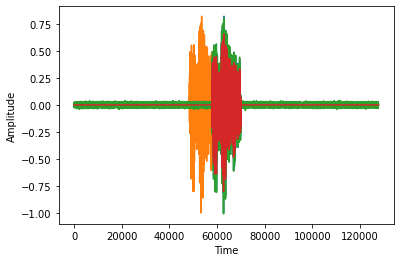

In [11]:
plot_sample(augmented_audio,100)

In [8]:
stfts = calc_stft(augmented_audio)

Augmentation  1


100%|██████████| 413/413 [00:03<00:00, 111.53it/s]


Augmentation  2


100%|██████████| 413/413 [00:03<00:00, 111.55it/s]


Augmentation  3


100%|██████████| 413/413 [00:04<00:00, 84.55it/s]


Augmentation  4


100%|██████████| 413/413 [00:03<00:00, 113.33it/s]


In [13]:
print("Augmented dataset size: ",stfts.nbytes/(1e9), 'GB')

Augmented dataset size:  3.3866 GB


In [ ]:
stfts_1D = np.zeros(stfts[0].shape)
stfts_1D = stfts[0]
for i in tqdm(range(1,stfts.shape[0])):
    stfts_1D = np.concatenate((stfts_1D,stfts[i]), axis = 0)
    stfts[i] = None
print("Augmented dataset size: ",stfts_1D.nbytes/(1e9), 'GB')

 67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

In [ ]:
spec_plot(stfts_1D[420,:,:])

### Data preparation

In [9]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from sklearn.model_selection import train_test_split


tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
# Split in train and validation subsets
train_images, val_images, train_labels, val_labels = train_test_split(stfts[0], y, test_size=0.3, random_state=13052020)
stfts_1D = None

# explicitly illustrating standardization
def standardizeimg(img, mu, sigma):
    return (img-mu)/(sigma).astype(np.float32)

# save for scaling test data
mu_train = np.mean(train_images)
sigma_train = np.std(train_images)

# Standardize pixel distribution to have zero mean and unit variance
train_images = standardizeimg(img=train_images, mu=mu_train, sigma=sigma_train)
val_images = standardizeimg(img=val_images, mu=np.mean(val_images), sigma=np.std(val_images))

# adapt to format required by tensorflow; Using channels_last --> (n_samples, img_rows, img_cols, n_channels)
img_rows, img_cols = 1025, 250 # input image dimensions
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
val_images = val_images.reshape(val_images.shape[0], img_rows, img_cols, 1)

# convert class vectors to binary class matrices - one hot encoding
onehot_t = pd.get_dummies(train_labels)
label_list = onehot_t.columns
train_labels = onehot_t.to_numpy()

onehot_v = pd.get_dummies(val_labels)
val_labels = onehot_v.to_numpy()

num_classes = len(label_list)

In [ ]:
print("Training set:")
print(" > images:", train_images.shape)
print(" > labels:", train_labels.shape)
print("Validation set:")
print(" > images:", val_images.shape)
print(" > labels:", val_labels.shape)

### Create architecture

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Conv2D(filters=64,
                 kernel_size=3,
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2, strides=None))

model.add(Dropout(rate=0.40))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

### Compile and train model

In [ ]:
# specify optimization strategy and metric used for monitoring during training
model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['categorical_accuracy'])

# the history object will contain a record of loss and metric values during training
history = model.fit(train_images, train_labels,
                    batch_size=256,
                    epochs=3,
                    verbose=1,
                    validation_data=(val_images, val_labels))

In [ ]:
# model.layers will print a list of layer parameters/values
filters1, biases1 = model.layers[0].get_weights()
filters2, biases2 = model.layers[2].get_weights()

# normalize filter values to range 0-1 for better colormapping during plotting
def norm_filter(kernel):
    return (kernel - np.min(kernel)) / (np.max(kernel) - np.min(kernel))

print('1st convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters1[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)
plt.show()

print('2nd convolution layer:')
fig, axs = plt.subplots(2,5, figsize=(10, 6))
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(norm_filter(filters2[:,:,0,i]), cmap=plt.cm.binary)
    axs[i].set_xticks([]); axs[i].set_yticks([]); axs[i].grid(False)

### Evaluation

In [ ]:
# evaluating model using all data (not in batches)
val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=2)

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,12))
fs_L, fs_M, fs_S = 18, 16, 14
ax[0].plot(history.history['categorical_accuracy'], label='train')
ax[0].plot(history.history['val_categorical_accuracy'], label='validation')
ax[0].set_xlabel('Epoch', fontsize=fs_M)
ax[0].set_ylabel('Accuracy', fontsize=fs_M)
ax[0].tick_params(axis='both', which='major', labelsize=fs_S)
ax[0].set_title('Final mean validation accuracy: {}'.format(val_acc), fontsize=fs_M)
ax[0].set_xticks(range(0,5))
ax[0].legend(loc='lower right', fontsize=fs_M)

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='validation')
ax[1].set_xlabel('Epoch', fontsize=fs_M)
ax[1].set_ylabel('Loss', fontsize=fs_M)
ax[1].tick_params(axis='both', which='major', labelsize=fs_S)
ax[1].set_xticks(range(0,5))
ax[1].legend(loc='upper right', fontsize=fs_M)

plt.show()

### Inference

In [ ]:
# using until now unseen data
predicted_prob = model.predict(val_images)
predictions = np.argmax(predicted_prob, axis=1)

In [ ]:
with tf.compat.v1.Session() as sess:
    confusion_matrix = tf.compat.v1.confusion_matrix(np.argmax(val_labels, axis=1), predictions=predictions, num_classes=num_classes)
    confusion_matrix_to_Print = sess.run(confusion_matrix)
    print(confusion_matrix_to_Print)
    
error_rate = (np.sum(confusion_matrix_to_Print)-np.sum(np.diag(confusion_matrix_to_Print))) / np.sum(np.diag(confusion_matrix_to_Print))
inf_acc = 1-error_rate
print('Error rate: ', error_rate)
print('Accuracy: ', inf_acc)